In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from torch import nn, optim
from thop import profile
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)

1.1.0


In [3]:
def train_model(model, optimizer, loss, num_epoches=100, verbose=10):
    '''
    输入
    model: 需要训练的模型
    optimizer: 优化器
    loss: 损失函数
    num_epoches: 训练次数
    verbose: 训练信息的打印间隔

    输出
    model: 训练完成的模型
    accuracy_train: 训练集正确率
    accuracy_test: 测试集正确率
    '''
    dur = []
    for epoch in range(1, num_epoches+1):
        # if epoch >= 3:
        #     t0 = time.time()
        l_sum, n, total_acc = 0.0, 0, 0
        t0 = time.time()
        for X, y  in trainloader:
            X = X.to(device)
            y = y.to(device)
            y_pred_proba = model(X)
            l = loss(y_pred_proba, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.item()
            n += y.shape[0]
            y_pred = torch.argmax(y_pred_proba, axis=1)
            total_acc += torch.sum(y==y_pred).item()
        
        dur.append(time.time() - t0)
        accuracy_train = total_acc / n
        accuracy_test = eval_test(model)
        if verbose > 0 and epoch % verbose == 0:
            print("Epoch {:05d} | Loss {:.4f} | accuracy_train {:.4f} | accuracy_test {:.4f} | Time(s) {:.4f}".format(
                epoch, l_sum/batch_size, accuracy_train, accuracy_test, np.mean(dur)))
    return model, accuracy_train, accuracy_test

In [4]:
def eval_test(model):
    '''
    输入:
    model: 需要进行测试的模型

    输出:
    测试集正确率
    '''
    l_sum, n, total_acc = 0.0, 0, 0
    for X, y  in testloader:
        X = X.to(device)
        y = y.to(device)
        y_pred_proba = model(X)
        n += y.shape[0]
        y_pred = torch.argmax(y_pred_proba, axis=1)
        total_acc += torch.sum(y==y_pred).item()
    return total_acc/n

#### 读取训练集 & 测试集

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)# 对数据进行标准化 [0, 1] -> [-1, 1]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, 
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, 
                                        transform=transform)

0it [00:00, ?it/s]

100%|██████████████████████████████████████████████████████████████▉| 170401792/170498071 [02:49<00:00, 1739538.81it/s]

Files already downloaded and verified


170500096it [03:00, 1739538.81it/s]                                                                                    

trainset 样本数：50000

testset 样本数：10000

样本维度：n_channels = 3
         height = 32
         width = 32

In [6]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=0)
calsses = ['plane', 'cat', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

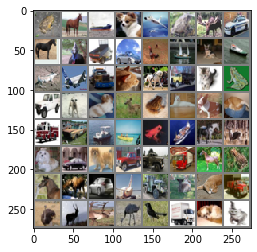

In [7]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

#### Transformer Encoder

In [8]:
class ScaledDotProductAttention(nn.Module):
    def __init_():
        super(ScaledDotProductAttention, self).__init_()
    
    def forward(self, Q, K, V):
        # K (batch_size, n_heads, len_k, d_k)
        # Q (batch_size, n_heads, len_q(=len_k), d_q(=d_k)) # n_heads means multi heads
        # V (batch_size, n_heads, len_v(=len_k), d_v)
        d_k = K.shape[-1]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # FLOPs的包计算时考虑不到matmul
        # scores(batch_size, n_heads, len_q, len_k)
        # scores.masked_fill(attn_mask, -1e9)
        attn = F.softmax(scores, dim=-1)
        contexts = torch.matmul(attn, V)
        # contexts (batch_size, n_heads, len_v(=len_k), d_v)
        return contexts, attn

In [9]:
class MultHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(MultHeadAttention, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.fc = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, Q, K, V):
        # K (batch_size, len_k, d_model)
        # Q (batch_size, len_q(=len_k), d_model)
        
        # V (batch_size, len_v(=len_k), d_model)
        residual, batch_size = Q, Q.shape[0]
        q = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)
        # attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)
        # attn_mask (batch_size, n_heads, len_k, len_q)
        context, attn = ScaledDotProductAttention()(q, k, v)
        # contexts (batch_size, n_heads, len_v(=len_k), d_v)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        # contexts (batch_size, len_v(=len_k), n_heads * d_v)
        output = self.fc(context)
        # output (batch_size, len_v(=len_k), d_model)
        output = output + residual
        return self.layer_norm(output), attn


In [10]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.fc1 = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
    def forward(self, inputs):
        # inputs (batch_size, len_q, d_model)
        residual = inputs
        output = self.fc1(inputs)
        output = F.relu(output)
        output = self.fc2(output)
        return self.layer_norm(output + residual)

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_k, d_v, n_heads):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.enc_self_attn = MultHeadAttention(d_model, d_k, d_v, n_heads)
        self.pos_ffn = PoswiseFeedForwardNet(d_model)
    
    def forward(self, enc_inputs):
        # enc_inputs (batch_size, len_k, d_model)
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs)
        enc_outputs = self.pos_ffn(enc_outputs)
        # enc_outputs (batch_size, len_q, d_model)
        return enc_outputs, attn

In [12]:
class Encoder(nn.Module):
    def __init__(self, n, d_model, d_k, d_v, n_heads, n_layers):
        super(Encoder, self).__init__()
        # self.src_emb = nn.Embedding(n, d_model)
        # self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(n+1, d_model),freeze=True)
        self.n_layers = n_layers
        self.layers = nn.ModuleList([EncoderLayer(d_model,d_k, d_v, n_heads) for _ in range(n_layers)])
        # self.position = torch.LongTensor([[i for i in range(1, n+1)]]).to(device)
        self.position = nn.Parameter(torch.randn(1, n+1, d_model))
    def forward(self, enc_inputs):
        # enc_inputs (batch_size, h*w, patch_height*patch_width*in_channels)
        # enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        batch_size, n, _ = enc_inputs.shape
        # pos_emb_vec = self.pos_emb(self.position)
        enc_outputs = enc_inputs + self.position[:, :n]
        # enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

#### VGG16

In [13]:
class vgg_cell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,
                stride=1, padding=1, pool=False, kernel_size_pool=2,
                stride_pool=2, padding_pool=0):
        super(vgg_cell, self).__init__()
        self.net = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ])
        if pool:
            self.net.append(nn.MaxPool2d(kernel_size=kernel_size_pool,
                                         stride=stride_pool,
                                         padding=padding_pool))
        self.net = nn.Sequential(*self.net)
    def forward(self, x):
        # x: (batch_size, n_channels, h, w)
        x = self.net(x)
        return x

class vgg(nn.Module):
    def __init__(self, config, num_classes=10):
        super(vgg, self).__init__()
        self.num_classes = num_classes
        self.net = nn.ModuleList([])
        for in_channels, out_channels, kernel_size, stride, padding, pool in config:
            self.net.append(vgg_cell(in_channels=in_channels,
                                     out_channels=out_channels,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=padding,
                                     pool=pool))
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        # self.fc1 = nn.Linear(25088, 4096, bias=True)
        # self.fc2 = nn.Linear(4096, 4096, bias=True)
        # self.fc3 = nn.Linear(4096, 1000, bias=True)
        self.output_layer = nn.Linear(512, self.num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mlp=True):
        batch_size = x.shape[0]
        for cell in self.net:
            x = cell(x)
        if mlp:
            x = x.view(batch_size, -1)
            x = self.output_layer(x)
        return x

#### ViT

In [14]:
class ViT(nn.Module):
    def __init__(self, image_size, in_channels, patch_size, num_classes, 
                 dim, depth, heads, mlp_dim, d_k=64, d_v=64, 
                 dropout=0, emb_dropout=0):
        super(ViT, self).__init__()
        image_height, image_width = image_size
        patch_height, patch_width = patch_size
        num_pathes = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = in_channels * patch_height * patch_width
        self.num_pathes = num_pathes
        self.patch_dim = patch_dim
        self.to_patch_layer = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Encoder(n=num_pathes+1,
                                    d_model=dim, 
                                    d_k=d_k, 
                                    d_v=d_v, 
                                    n_heads=heads, 
                                    n_layers=depth)
        # self.transformer_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads)
        # self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=depth, norm=nn.LayerNorm(dim))
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    
    def forward(self, img):
        batch_size = img.shape[0]
        img = img.view(batch_size, self.num_pathes, self.patch_dim)
        x = self.to_patch_layer(img)
        # cls_tokens = self.cls_token.repeat(batch_size, 1, 1)
        # x = torch.cat((cls_tokens, x), dim=1)
        # x = self.dropout(x)
        x, _ = self.transformer(x)
        x = x.mean(dim=1)
        x = self.mlp_head(x)
        return x

#### ViT FLOPs

In [15]:
def calc_vit_flops(vit_params, batch_size):
    in_channels = vit_params['in_channels']
    patch_height, patch_width = vit_params['patch_size']
    image_height, image_width = vit_params['image_size']
    num_pathes = (image_height // patch_height) * (image_width // patch_width)
    patch_dim = in_channels * patch_height * patch_width

    d_model = vit_params['dim']
    num_classes = vit_params['num_classes']
    d_k = vit_params['d_k']
    d_q = d_k
    d_v = vit_params['d_v']
    heads = vit_params['heads']
    depth = vit_params['depth']
    len_k, len_q, len_v = num_pathes, num_pathes, num_pathes

    '''
    batch_size * patch_dim * d_model +
    (拉平操作)

    (batch_size * d_model * heads * (len_k * d_k + len_q * d_q + len_v * d_v) + 
    (生成 key, query, value矩阵)

    batch_size * heads * len_q * d_k * len_k + 
    (使用key, query计算attention)

    batch_size * heads * len_q * len_k * d_v + batch_size * len_q * heads * d_v * d_model + 
    (使用attention, value计算 output)

    batch_size * len_q * d_model * d_model * 2) * depth + 
    (FeedForward)

    batch_size * d_model * num_classes
    (最终输出)
    '''

    FLOPs = batch_size * patch_dim * d_model + \
            (batch_size * d_model * heads * (len_k * d_k + len_q * d_q + len_v * d_v) + \
            batch_size * heads * len_q * d_k * len_k + \
            batch_size * heads * len_q * len_k * d_v + batch_size * len_q * heads * d_v * d_model + \
            batch_size * len_q * d_model * d_model * 2) * depth + \
            batch_size * d_model * num_classes

    return FLOPs

vit_params = {
            'image_size': (8, 8), 
            'in_channels': 128, 
            'patch_size': (1, 1), 
            'num_classes': 10, 
            'dim': 128, 
            'depth': 5, 
            'heads': 4,
            'mlp_dim': 128, 
            'd_k': 32,
            'd_v': 32, 
            'dropout': 0}
img = torch.randn(1, 128, 8, 8)
model_vit = ViT(**vit_params)
print(calc_vit_flops(vit_params, 1))
flops, params = profile(model_vit, inputs=(img, ))
print(flops, params)

36717824
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.normalization.LayerNorm'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.MultHeadAttention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.PoswiseFeedForwardNet'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.EncoderLayer'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Encoder'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.ViT'>. Treat it as zero Macs and z

### Model A

In [16]:
class vgg_vit(nn.Module):
    def __init__(self, vgg_params, vit_params):
        super(vgg_vit, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.vit = ViT(**vit_params)
    def forward(self, img):
        x = self.vgg(img, mlp=False)
        x = self.vit(x)
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }

vit_params = {
            'image_size': (8, 8), 
            'in_channels': 128, 
            'patch_size': (1, 1), 
            'num_classes': 10, 
            'dim': 128, 
            'depth': 5, 
            'heads': 4,
            'mlp_dim': 128, 
            'd_k': 32,
            'd_v': 32, 
            'dropout': 0}
'''
卷积层输入为(batch_size, 3, 32, 32)
卷积层输出为(batch_size, 128, 8, 8)
Transformer输入为(batch_size, 128, 8, 8) -> (batch_size, 64, 128)
'''
model_A = vgg_vit(vgg_params, vit_params)
model_vgg = vgg(**vgg_params)

In [17]:
img = torch.randn(1, 3, 32, 32)
vgg_flops, vgg_params_num = profile(model_vgg, inputs=(img, False))
vit_flops = calc_vit_flops(vit_params, 1)
model_A_flops = vgg_flops + vit_flops
_, model_A_params_num = profile(model_A, inputs=(img, ))
print('Model A Params Num: ', model_A_params_num)
print('Model A FLOPS: ', model_A_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 't

### Model B

In [18]:
class vgg_fc(nn.Module):
    def __init__(self, vgg_params):
        super(vgg_fc, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.fc1 = nn.Linear(8192, 63)
        self.fc2 = nn.Linear(63, 10)
    def forward(self, img):
        batch_size = img.shape[0]
        x = self.vgg(img, mlp=False)
        x = x.view(batch_size, -1)
        x = self.fc2(self.fc1(x))
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }
model_B = vgg_fc(vgg_params)

In [19]:
img = torch.randn(1, 3, 32, 32)
model_B_flops, model_B_params_num = profile(model_B, inputs=(img, ))
print('Model B Params Num: ', model_B_params_num)
print('Model B FLOPS: ', model_B_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_fc'>. Treat it as zero Macs and zero Params.
Model B Params Num:  777727.0
Model B FLOPS:  97247862.0


### Model C

In [20]:
class vgg_fc_FLOPs(nn.Module):
    def __init__(self, vgg_params):
        super(vgg_fc_FLOPs, self).__init__()
        self.vgg = vgg(**vgg_params)
        self.fc1 = nn.Linear(8192, 4096)
        self.fc2 = nn.Linear(4096, 768)
        self.fc3 = nn.Linear(768, 10)
    def forward(self, img):
        batch_size = img.shape[0]
        x = self.vgg(img, mlp=False)
        x = x.view(batch_size, -1)
        x = self.fc3(self.fc2(self.fc1(x)))
        return x

vgg_params ={
    'config': [
    (3, 64, 3, 1, 1, False),    #3 3
    (64, 64, 3, 1, 1, True),    #4 7
    (64, 128, 3, 1, 1, False),  #3 10
    (128, 128, 3, 1, 1, True),  #4 14
    # (128, 256, 3, 1, 1, False), #3 17
    # (256, 256, 3, 1, 1, False), #3 20
    # (256, 256, 3, 1, 1, True),  #4 24
    # (256, 512, 3, 1, 1, False), #3 27
    # (512, 512, 3, 1, 1, False), #3 30
    # (512, 512, 3, 1, 1, True),  #4 34
    # (512, 512, 3, 1, 1, False), #3 37
    # (512, 512, 3, 1, 1, False), #3 40
    # (512, 512, 3, 1, 1, True),  #4 44
    ], 
    'num_classes': 10
    }
model_C = vgg_fc_FLOPs(vgg_params)

In [21]:
img = torch.randn(1, 3, 32, 32)
model_C_flops, model_C_params_num = profile(model_C, inputs=(img, ))
print('Model C Params Num: ', model_C_params_num)
print('Model C FLOPS: ', model_C_flops)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_cell'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.vgg'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.vgg_fc_FLOPs'>. Treat it as zero Macs and zero Params.
Model C Params Num:  36973642.0
Model C FLOPS:  133438976.0


In [22]:
print('Model A Params Num: ', model_A_params_num)
print('Model B Params Num: ', model_B_params_num)

Model A Params Num:  774090.0
Model B Params Num:  777727.0


In [23]:
print('Model A FLOPS: ', model_A_flops)
print('Model C FLOPS: ', model_C_flops)

Model A FLOPS:  133448960.0
Model C FLOPS:  133438976.0
